In [3]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler

import numpy as np

torch.manual_seed(8)

## Loading Dataframe

In [4]:
#FILEPATH = './NASAsummer/GANS/CsI_data.csv'
FILEPATH = './NASAsummer/GANS/test_sample1.csv'
CATEGORY_TYPE = 'CsI'
COLUMN = 'category_label'



training_data = pd.read_csv(FILEPATH)
training_data = training_data.loc[training_data[COLUMN] == CATEGORY_TYPE]
training_data.drop(training_data.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)

# Get Metadata to Remerge
metadata = training_data.loc[:,'Laser_Energy':'formationprocess_label']
training_data.drop(training_data.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)

#Get USIDS to Remerge
USID = training_data['USID'].copy()
training_data = training_data.drop(columns =['USID'])

#MS Data to be read by NN
features = training_data.iloc[:, 0:]
features = features.drop(features.tail(133).index)

print('Dataset Size = ',features.shape)


#drop last 133 columns
## Note, Consider zipping USIDS with Labels and Training data,and eventually zipping everything together again.

Dataset Size =  (6656, 1050)


## Data Preprocessing: attaching labels, etc.

6656
<class 'numpy.ndarray'> <class 'torch.Tensor'>


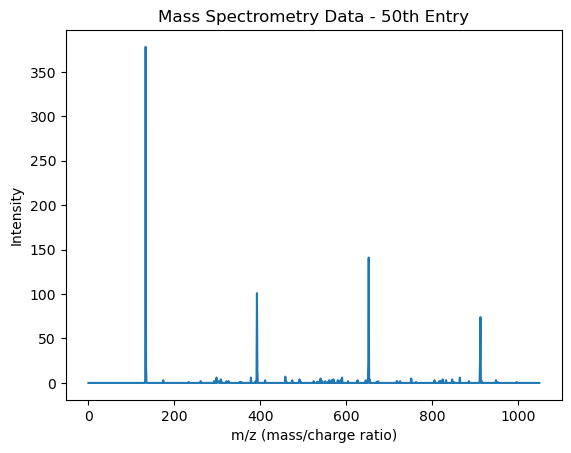

In [5]:
scaler = MinMaxScaler()
real_data = scaler.fit_transform(features)
real_data_length = len(real_data)
real_labels = torch.zeros(real_data_length)
unscaled = scaler.inverse_transform(real_data)

real_set = [
    (real_data[i], real_labels[i]) for i in range(real_data_length)
]
print(len(real_labels))

print(type(real_data), type(real_labels))

entry = unscaled[49]
plt.plot(entry)
plt.title('Mass Spectrometry Data - 50th Entry')
plt.xlabel('m/z (mass/charge ratio)')
plt.ylabel('Intensity')
plt.show()


In [6]:
batch_size = 128
real_data_loader = torch.utils.data.DataLoader(
    real_set, batch_size = batch_size, shuffle = True
) ## Shuffling Data

## Classes that We will use to Train GANS in the future as well!

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__() ## importing class from super
        self.model = nn.Sequential(
            nn.Linear(1050, 512), ## Note this is because there is 1050 inputs
            ##            nn.BatchNorm1d(512), consider
            nn.LeakyReLU(0.2), #increased size for first layer
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            ##nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2), #Uses ReLU activation
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            ##nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1), #Last layer goes from 64 neurons to 1
            nn.Sigmoid(), ##using sigmoidal activation to create a single neuron output
        )
    def forward(self, x):
            output = self.model(x) #describes how the output of the model is calculated
            return output 
discriminator = Discriminator()

In [8]:
class Generator(nn.Module): # Inherits from the nn.Module
    def __init__(self, noise_dim = 100):
        super().__init__() ##allows you to create a nn architecture
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256), ## taking noise vector of 100 to have more diversity
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            #nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1050),  # Output layer producing 1050 features
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        return output

noise_dim = 100
generator = Generator(noise_dim = noise_dim)
noise = torch.randn(1,noise_dim)
generated_data = generator(noise)
print(generated_data)

tensor([[ 0.0045,  0.0118, -0.0043,  ...,  0.0130,  0.0036,  0.0268]],
       grad_fn=<TanhBackward0>)


In [9]:
lr = .001
num_epochs = 30
loss_function = nn.BCELoss()
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = lr)
optimizer_g = torch.optim.Adam(generator.parameters(), lr = lr)


In [24]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(real_data_loader):
        fake_labels = torch.zeros((batch_size, 1))
        real_labels = torch.ones((batch_size, 1))
        #print(fake_labels.shape, real_labels.shape)
        
        latent_space_samples = torch.randn((batch_size, noise_dim))
        generated_samples = generator(latent_space_samples)

        all_samples = torch.cat((real_samples.to(torch.float32) , generated_samples.to(torch.float32)))
        all_sample_labels = torch.cat(
            (real_labels, fake_labels)
        )
        all_sample_labels = all_sample_labels
        #print(type(all_samples))
        #print(all_sample_labels.shape)
        
         #Train the discriminator
        discriminator.zero_grad() # clear gradients at each step to avoid accumulation
        output_discriminator = discriminator(all_samples) #calculate output of the batch
        #print(output_discriminator.shape, all_sample_labels.shape)
        loss_discriminator = loss_function(
            input = output_discriminator.view(-1), target = all_sample_labels.view(-1) ##loss function
        )
        loss_discriminator.backward() #calculate gradients to update weights (gradient descent)
        optimizer_d.step() #optimizer_discriminator.step()

        #Time to train the generator
        
        #data for generator
        latent_space_samples = torch.randn((batch_size, noise_dim))

        #Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_labels
        )
        loss_generator.backward()
        optimizer_g.step()

         # Show loss
        if epoch % 10 == 0 and n == 5:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
        


Epoch: 0 Loss D.: 0.6936497092247009
Epoch: 0 Loss G.: 0.6963382363319397


KeyboardInterrupt: 

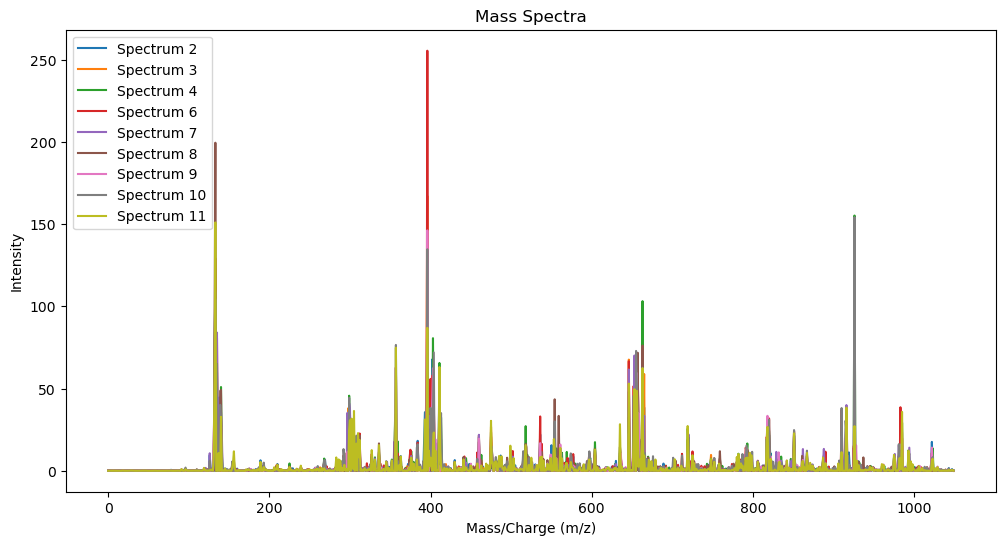

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

NUM_BATCHES = 5
NUM_TEST_IDS = 200


for i in range(NUM_BATCHES):
    latent_space_samples = torch.randn(NUM_TEST_IDS, noise_dim) #100 is number of samples to make
    generated_samples = generator(latent_space_samples)
    generated_samples = generated_samples.detach()
    generated_samples = scaler.inverse_transform(generated_samples)
    graphed = generated_samples.clip(min = 0)


    DF = pd.DataFrame(graphed) 
    DF.insert(0, 'USID', USID)

    for col in metadata.columns:
        DF[col] = metadata[col]


    DF.to_csv(f"{CATEGORY_TYPE}_batch_{i}.csv")




# Select a few spectra to plot
num_spectra_to_plot = 4
spectra_indices = [1, 2, 3, 5, 6, 7, 8, 9, 10] # Change these indices to plot different spectra

plt.figure(figsize=(12, 6))

for i in spectra_indices:
    plt.plot(graphed[i], label=f'Spectrum {i+1}')

plt.title("Mass Spectra")
plt.xlabel("Mass/Charge (m/z)")
plt.ylabel("Intensity")
plt.legend()
plt.show()


In [11]:

# Assume generator and discriminator are your PyTorch models
import torch

# Save the generator model
torch.save(generator.state_dict(), 'CsI_Generator.pth')

# Save the discriminator model
torch.save(discriminator.state_dict(), 'CsI_Discriminator.pth')

print("Saved models to disk")



Saved models to disk
